# Fingerprint

O algorítmo de fingeprint consiste na criação de um repositório de dados que contém amostras das informações dos dados de treinamento, com o objetivo de identificar caracteristicas de regiões específicas. O sustema usa esse repositório como ponto de referência com o qual comparar os dados coletados em um ponto desconhecido com o objetivo de estimar qual o ponto no repositório mais próximo a este novo ponto de interesse.

O algoritmo utiliza de distância euclidiana entre os pontos.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import contextily as ctx

Importando os dados e removendo coluna de id e coluna sem nome

In [93]:
df_bts = pd.read_csv('../../input_data/02_pre_processed_files/bts.csv')
df_test_alunos = pd.read_csv('../../input_data/02_pre_processed_files/meds_test_alunos.csv')
df_train_alunos = pd.read_csv('../../input_data/02_pre_processed_files/meds_train_alunos.csv')
test_ponto_id = df_test_alunos.pop('ponto_id')
train_ponto_id = df_train_alunos.pop('ponto_id')

In [94]:
df_train_alunos = df_train_alunos.loc[:, ~df_train_alunos.columns.str.contains('^Unnamed')]
df_train_alunos

rssi_1_1    rssi_1_2    rssi_1_3    rssi_2_1    rssi_2_2    rssi_2_3   
0    -103.705000 -110.425000 -107.381667 -110.330000 -108.345000 -106.590000  \
1    -105.225000 -115.000000 -105.210000 -115.000000 -105.835000 -115.000000   
2    -102.610000 -115.000000 -101.380000 -115.000000 -104.295000  -97.360000   
3     -89.140000  -97.251429  -86.642857  -96.036667  -96.592500  -92.460000   
4    -109.088333 -107.200000 -107.010000 -108.430000 -104.845714 -101.435714   
...          ...         ...         ...         ...         ...         ...   
6758 -105.225000 -115.000000 -105.210000 -115.000000 -105.835000 -115.000000   
6759 -105.225000 -115.000000 -105.210000 -115.000000 -105.835000 -115.000000   
6760 -105.225000 -115.000000 -105.210000 -115.000000 -105.835000 -115.000000   
6761 -109.088333 -107.200000 -107.010000 -108.430000  -97.200000  -98.148571   
6762  -89.254286  -91.887143  -89.297143  -85.120000  -83.190000  -84.626190   

        rssi_3_1    rssi_3_2  rssi_3_3  delay_1  delay_2  delay_3       lat   
0    -107.153333 -102.120000 -115.0000      5.0      3.0      2.0 -8.055786  \
1     -88.470000  -94.024286 -108.1200      5.0      3.0      2.0 -8.055784   
2     -96.980000  -99.572500 -115.0000      5.0      3.0      2.0 -8.055506   
3     -86.813333 -102.688000  -87.2700      4.0      7.0      2.0 -8.050390   
4    -103.065000 -102.110000 -115.0000      5.0      3.0      2.0 -8.055380   
...          ...         ...       ...      ...      ...      ...       ...   
6758  -93.005000  -97.114286 -108.1200      5.0      3.0      2.0 -8.055784   
6759  -87.315000  -88.735714 -108.1200      5.0      3.0      2.0 -8.055784   
6760  -95.165000  -90.705714 -108.1200      5.0      3.0      2.0 -8.055784   
6761  -99.840000  -94.665000 -115.0000      5.0      3.0      2.0 -8.055380   
6762  -91.120000 -101.740000  -96.3725      5.0      3.0      3.0 -8.055320   

            lon  indoor  
0    -34.951505    True  
1    -34.951608    True  
2    -34.951693    True  
3    -34.959630   False  
4    -34.951736    True  
...         ...     ...  
6758 -34.951608    True  
6759 -34.951608    True  
6760 -34.951608    True  
6761 -34.951736    True  
6762 -34.951080   False  

[6763 rows x 15 columns]

In [95]:
df_test_alunos = df_test_alunos.loc[:, ~df_test_alunos.columns.str.contains('^Unnamed')]
df_test_alunos

rssi_1_1    rssi_1_2    rssi_1_3    rssi_2_1  rssi_2_2    rssi_2_3   
0    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000  \
1    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000   
2    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000   
3    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000   
4    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000   
...          ...         ...         ...         ...       ...         ...   
2899  -78.377143  -93.530000  -74.481429  -89.900000  -94.2075  -85.220000   
2900  -79.580000  -84.140000  -74.481429  -95.280000  -94.1450  -93.030000   
2901  -77.652857 -101.310000  -79.640000  -93.238333  -99.8000  -93.584286   
2902  -77.367143  -89.474286  -79.270000  -97.160000  -98.4800  -94.844286   
2903  -79.520000  -89.868571  -71.890000  -97.040000  -92.1600  -94.717143   

       rssi_3_1    rssi_3_2  rssi_3_3  delay_1  delay_2  delay_3  
0    -90.930000  -84.113333 -115.0000      5.0      3.0      2.0  
1    -90.930000  -84.113333 -115.0000      5.0      3.0      2.0  
2    -90.930000  -86.090000 -115.0000      5.0      3.0      2.0  
3    -90.930000  -84.113333 -115.0000      5.0      3.0      2.0  
4    -90.930000  -84.113333 -115.0000      5.0      3.0      2.0  
...         ...         ...       ...      ...      ...      ...  
2899 -89.576667 -103.704000  -97.2200      1.0      4.0      4.0  
2900 -89.576667 -103.704000  -97.5000      1.0      4.0      4.0  
2901 -86.680000 -103.704000  -96.3650      1.0      4.0      4.0  
2902 -87.783333 -103.704000  -94.3275      1.0      4.0      5.0  
2903 -89.730000 -103.704000  -94.3275      1.0      4.0      5.0  

[2904 rows x 12 columns]

In [96]:
df_bts = df_bts.loc[:, ~df_bts.columns.str.contains('^Unnamed')]
df_bts

grupo    btsId btsNetNome      lat        lon  cch  azimuth    RssiId
0      1  BTS_1_1  PEMDL01_1 -8.04342 -34.952000  873        0  rssi_1_1
1      1  BTS_1_2  PEMDL01_2 -8.04342 -34.952000  872      120  rssi_1_2
2      1  BTS_1_3  PEMDL01_3 -8.04342 -34.952000  875      240  rssi_1_3
3      2  BTS_2_1  PEMDL08_1 -8.05289 -34.944672  865        0  rssi_2_1
4      2  BTS_2_2  PEMDL08_2 -8.05289 -34.944672  874      120  rssi_2_2
5      2  BTS_2_3  PEMDL08_3 -8.05289 -34.944672  871      240  rssi_2_3
6      3  BTS_3_1  PEMDL09_1 -8.05532 -34.957900  877        0  rssi_3_1
7      3  BTS_3_2  PEMDL09_2 -8.05532 -34.957900  881      120  rssi_3_2
8      3  BTS_3_3  PEMDL09_3 -8.05532 -34.957900  869      240  rssi_3_3

Separando features e features alvo

In [97]:
X = df_train_alunos.drop(columns=['lat', 'lon', 'indoor'])
y = df_train_alunos[['lat', 'lon', 'indoor']]

X_test = df_test_alunos

Separação de treino e validação

In [98]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Haversine é usado para distância real entre dois pontos

In [99]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371000
    return c * r

Distância euclidiana para calcular a proximidade entre valores do repositório com novos pontos

In [100]:
import math

def euclidean_distance(vector, w_vector):
    return vector_magnitude(subtract_vectors(vector, w_vector))

def vector_magnitude(vector):
   return math.sqrt(square_sum(vector))

def dot_product(vector, w_vector):
    return sum(v_i * w_i for v_i, w_i in zip(vector, w_vector))

def subtract_vectors(vector, w_vector):
    return [v_i - w_i for v_i, w_i in zip(vector, w_vector)]

def square_sum(vector):
    return dot_product(vector, vector)

Método de fingerprint, recebe um vetor que representa a impressão digital do dispositivo no ponto que desejamos identificar e o dataframe contendo as impressões digitais de referência. Retorna a posição latitude, longetude e indoors estimada

In [101]:
def fingerprint(vector, df):
    df['distance'] = [euclidean_distance(list(w), list(vector)) for w in df.values.tolist()]

    df = df.sort_values(by='distance', ascending=True)

    df = df.reset_index()

    return df.loc[0, ['lat', 'lon', 'indoor']]

Testando fingerprint com um vetor aleatório

In [102]:
v = [106,	122,	114,	123,	130,	111]
df_ = X_train.copy()
df_['lat'] = y_train['lat']
df_['lon'] = y_train['lon']
df_['indoor'] = y_train['indoor']
fingerprint(v,df_)

lat        -8.0542
lon      -34.94651
indoor       False
Name: 0, dtype: object

Gerando repositório de previsões de fingerprint para os dados de validação

In [103]:
Y_pred = [list(fingerprint(v,df_)) for _,v in X_val.iterrows()]

In [104]:
df2 = y_val.copy()
df2['lat_pred'] = [lat for lat,_,_ in Y_pred]
df2['lon_pred'] = [lon for _,lon,_ in Y_pred]
df2['indoor'] = [indoor for _,_,indoor in Y_pred]

In [105]:
distances = haversine(y_val['lat'], y_val['lon'], df2['lat_pred'], df2['lon_pred'])

Calculando distância média, máxima, mínima e desvio padrão

In [106]:
mean_distance = np.mean(distances)
max_distance = np.max(distances)
min_distance = np.min(distances)
std_distance = np.std(distances)

print(f"Mean Distance: {mean_distance:.2f} meters")
print(f"Max Distance: {max_distance:.2f} meters")
print(f"Min Distance: {min_distance:.2f} meters")
print(f"Standard Deviation of Distance: {std_distance:.2f} meters")
distances.describe()

Mean Distance: 22.30 meters
Max Distance: 664.62 meters
Min Distance: 0.00 meters
Standard Deviation of Distance: 70.41 meters


count    1353.000000
mean       22.295518
std        70.434797
min         0.000000
25%         0.000000
50%         0.000000
75%         8.021299
max       664.620685
dtype: float64

Mostrando distribuição das tistâncias

<Axes: >

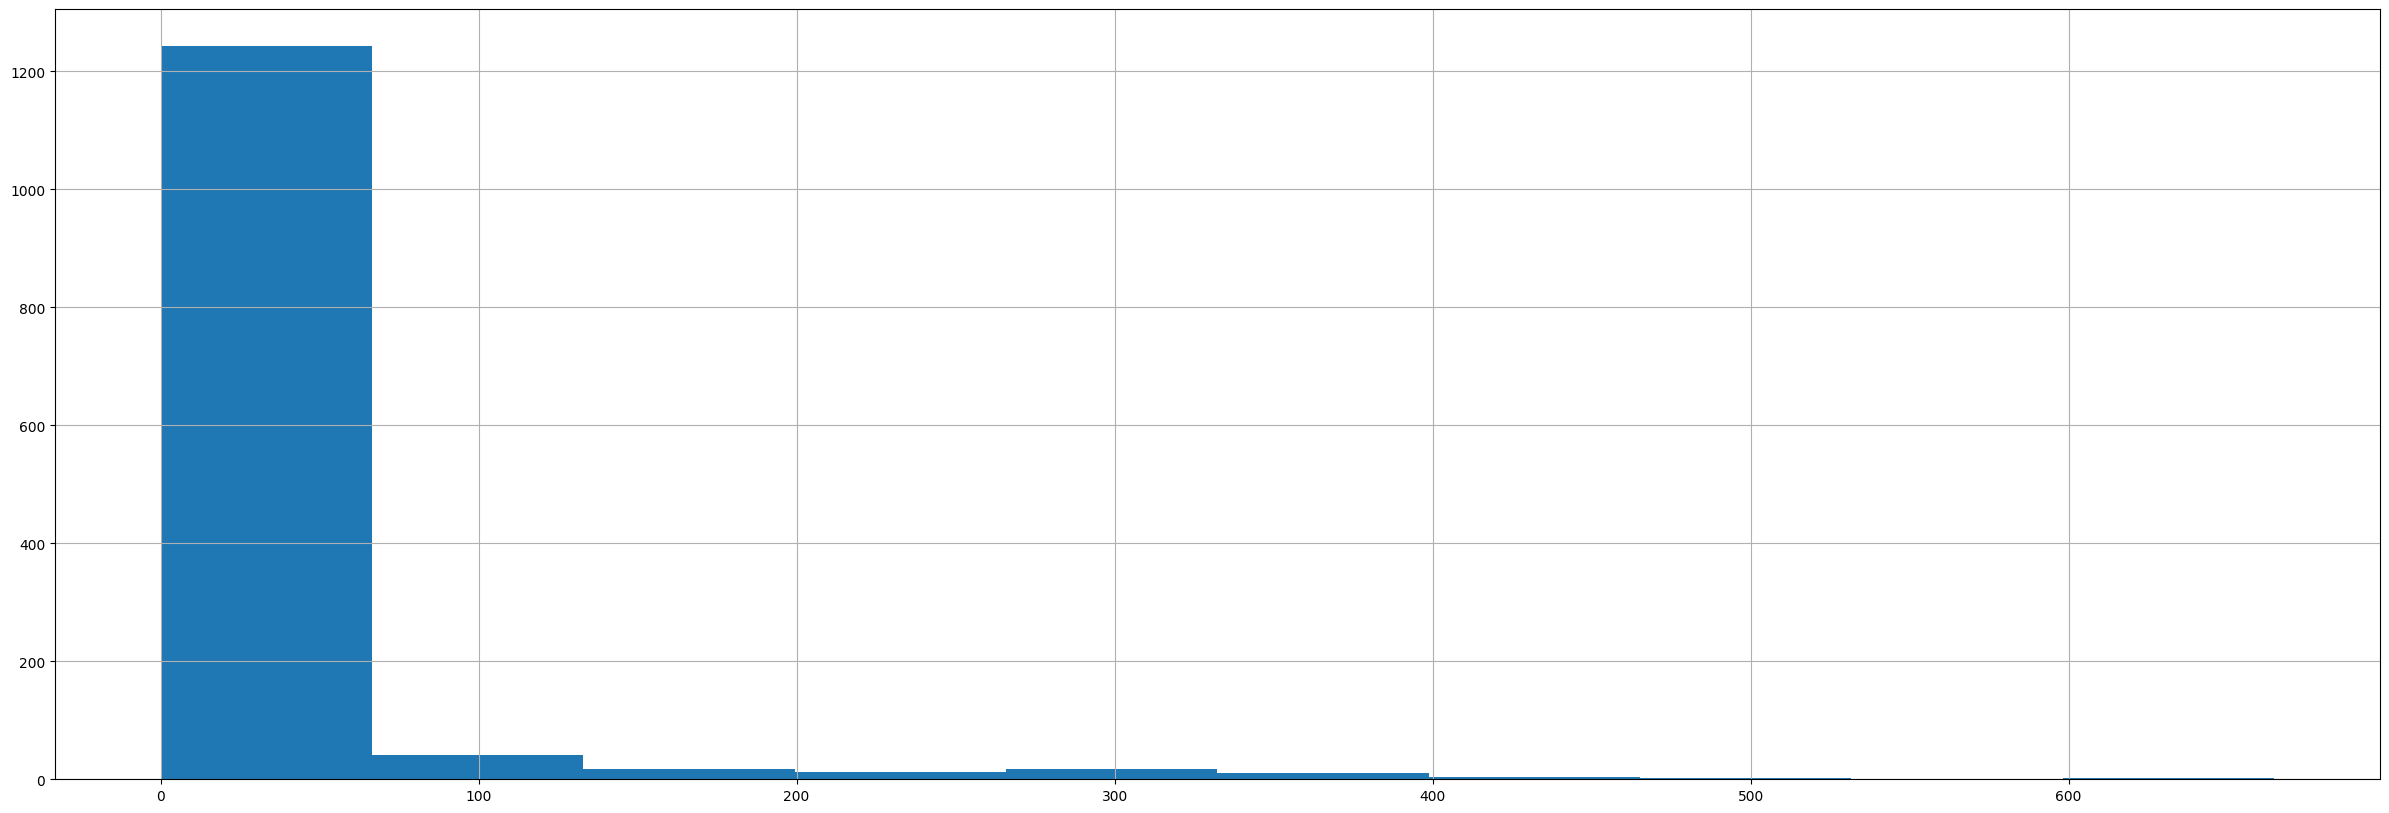

In [107]:
distances.hist(bins=10, figsize=(30,10))

<Axes: >

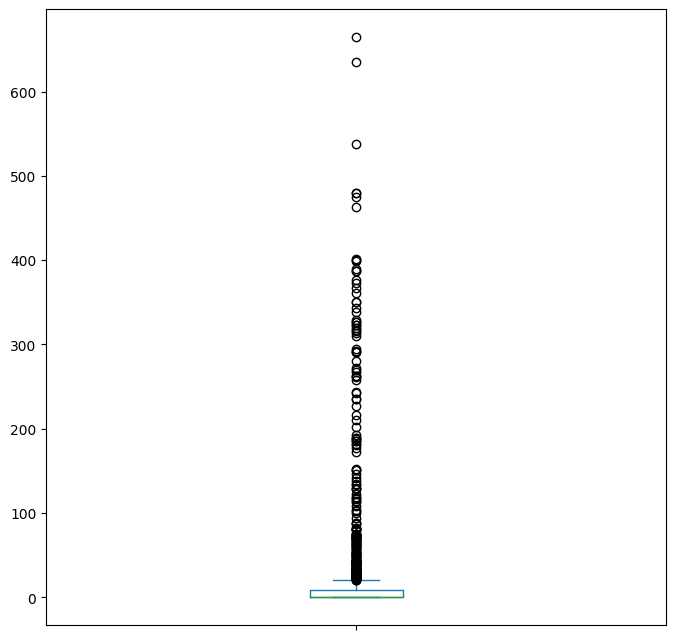

In [108]:
distances.plot(kind='box', figsize=(8,8))

Mapa de comparação: posições preditas vs. posições reais para banco de validação

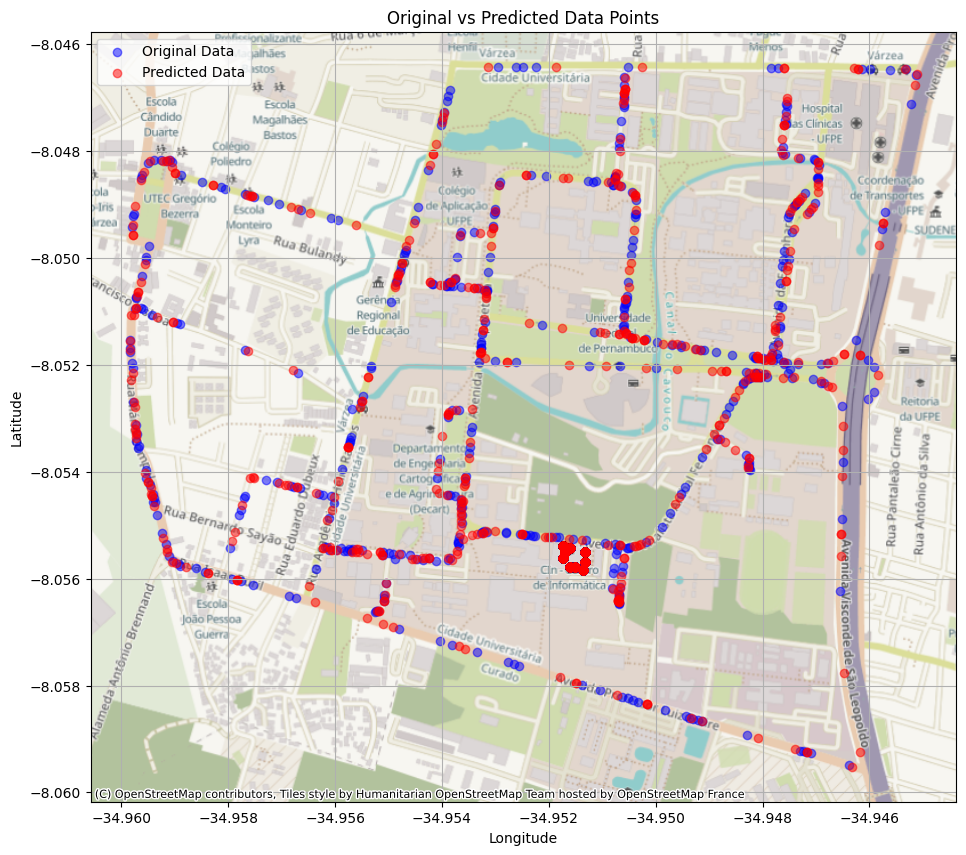

In [109]:
plt.figure(figsize=(12, 10))
plt.scatter(y_val['lon'], y_val['lat'], color='blue', label='Original Data', alpha=0.5)

plt.scatter(df2['lon_pred'], df2['lat_pred'], color='red', label='Predicted Data', alpha=0.5)
ctx.add_basemap(plt.gca(), crs='EPSG:4326')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original vs Predicted Data Points')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
X_test = df_test_alunos

In [111]:
y_test_pred = [list(fingerprint(v,df_)) for _,v in X_test.iterrows()]

In [112]:
lat_test_pred = [lat for lat,_,_ in y_test_pred]
lon_test_pred = [lon for _,lon,_ in y_test_pred]
indoor_test_pred = [indoor for _,_,indoor in y_test_pred]

In [113]:
df_test_alunos['lat_pred'] = lat_test_pred
df_test_alunos['lon_pred'] = lon_test_pred
df_test_alunos['indoor'] = indoor_test_pred
df_test_alunos

rssi_1_1    rssi_1_2    rssi_1_3    rssi_2_1  rssi_2_2    rssi_2_3   
0    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000  \
1    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000   
2    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000   
3    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000   
4    -115.000000 -115.000000 -115.000000 -115.000000 -115.0000 -115.000000   
...          ...         ...         ...         ...       ...         ...   
2899  -78.377143  -93.530000  -74.481429  -89.900000  -94.2075  -85.220000   
2900  -79.580000  -84.140000  -74.481429  -95.280000  -94.1450  -93.030000   
2901  -77.652857 -101.310000  -79.640000  -93.238333  -99.8000  -93.584286   
2902  -77.367143  -89.474286  -79.270000  -97.160000  -98.4800  -94.844286   
2903  -79.520000  -89.868571  -71.890000  -97.040000  -92.1600  -94.717143   

       rssi_3_1    rssi_3_2  rssi_3_3  delay_1  delay_2  delay_3  lat_pred   
0    -90.930000  -84.113333 -115.0000      5.0      3.0      2.0 -8.055605  \
1    -90.930000  -84.113333 -115.0000      5.0      3.0      2.0 -8.055605   
2    -90.930000  -86.090000 -115.0000      5.0      3.0      2.0 -8.055605   
3    -90.930000  -84.113333 -115.0000      5.0      3.0      2.0 -8.055605   
4    -90.930000  -84.113333 -115.0000      5.0      3.0      2.0 -8.055605   
...         ...         ...       ...      ...      ...      ...       ...   
2899 -89.576667 -103.704000  -97.2200      1.0      4.0      4.0 -8.046420   
2900 -89.576667 -103.704000  -97.5000      1.0      4.0      4.0 -8.048440   
2901 -86.680000 -103.704000  -96.3650      1.0      4.0      4.0 -8.049280   
2902 -87.783333 -103.704000  -94.3275      1.0      4.0      5.0 -8.046430   
2903 -89.730000 -103.704000  -94.3275      1.0      4.0      5.0 -8.049080   

       lon_pred  indoor  
0    -34.951728    True  
1    -34.951728    True  
2    -34.951728    True  
3    -34.951728    True  
4    -34.951728    True  
...         ...     ...  
2899 -34.951870   False  
2900 -34.952260   False  
2901 -34.955980   False  
2902 -34.951340   False  
2903 -34.956690   False  

[2904 rows x 15 columns]

Mapa de pontos preditos para casos de teste

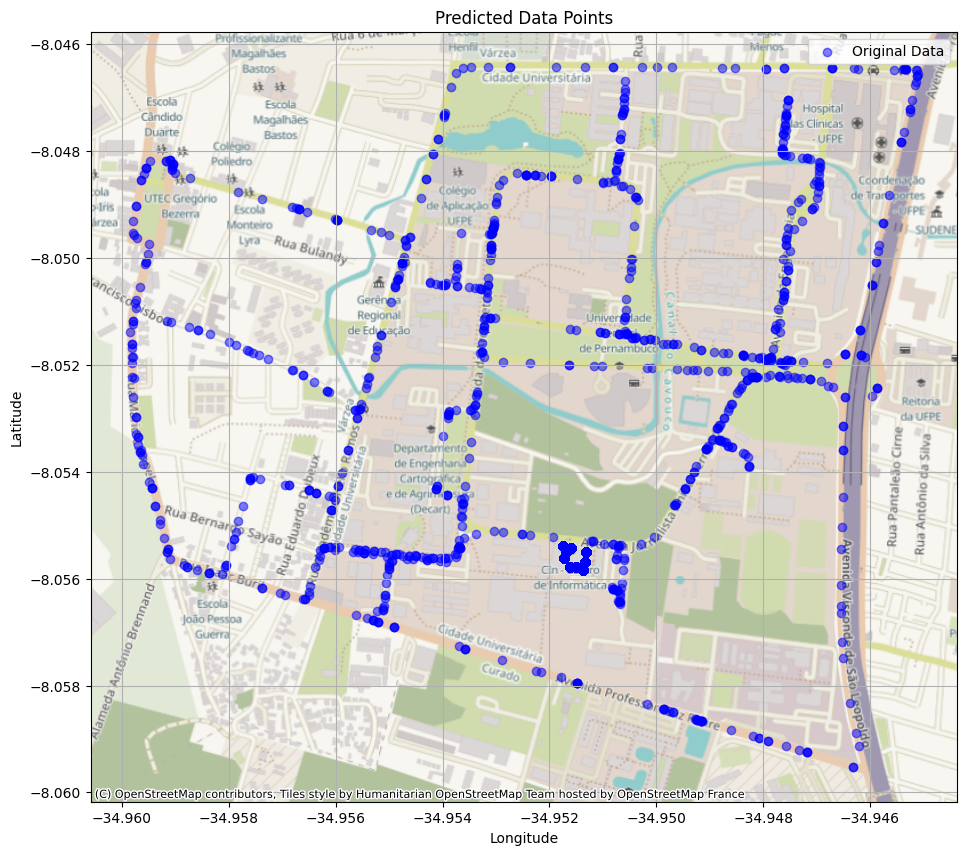

In [114]:
plt.figure(figsize=(12, 10))
plt.scatter(lon_test_pred, lat_test_pred, color='blue', label='Original Data', alpha=0.5)
ctx.add_basemap(plt.gca(), crs='EPSG:4326')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Data Points')
plt.legend()
plt.grid(True)
plt.show()

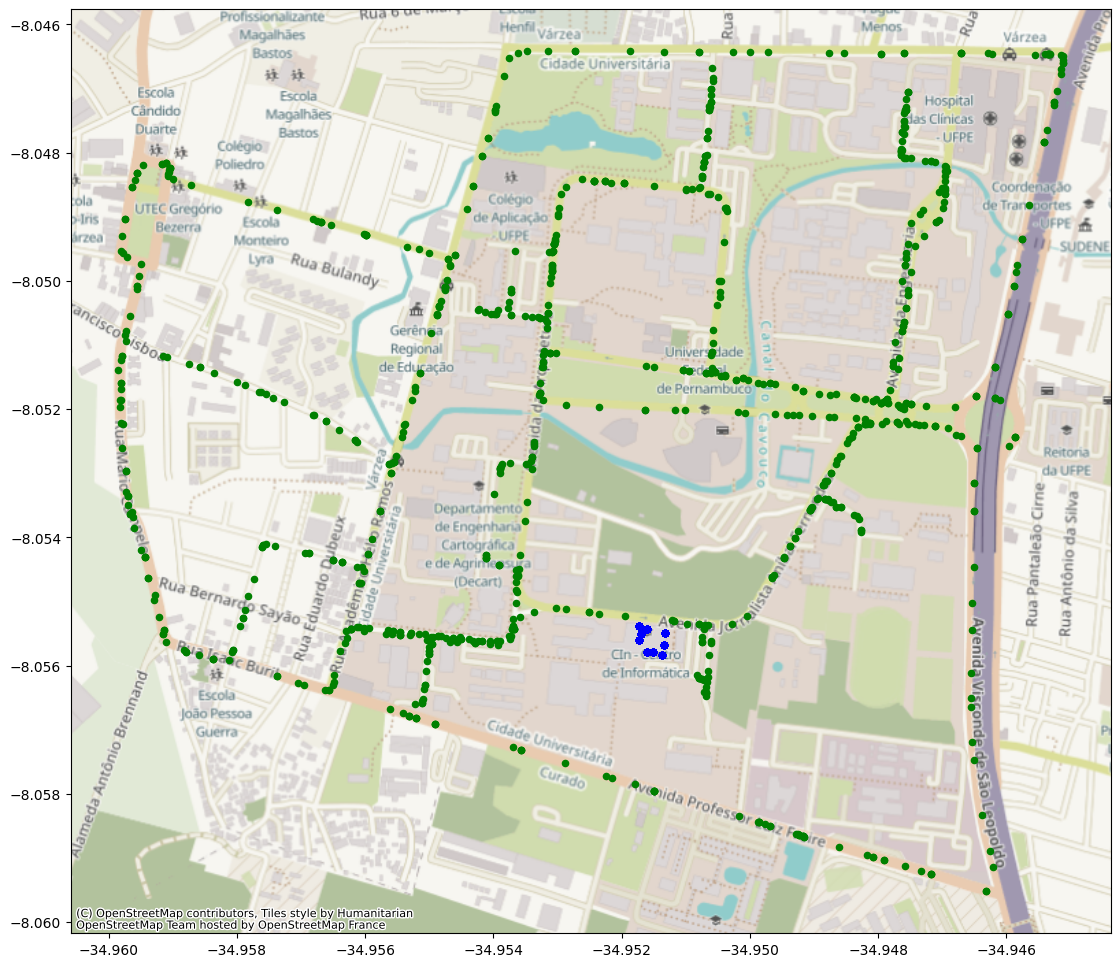

In [115]:
fig, subs = plt.subplots()

df_test_indoors = df_test_alunos[df_test_alunos['indoor'] == True]
df_test_indoors

df_test_outdoors = df_test_alunos[df_test_alunos['indoor'] == False]
df_test_outdoors

subs.scatter(df_test_indoors['lon_pred'], df_test_indoors['lat_pred'], color='blue', s = 20)
subs.scatter(df_test_outdoors['lon_pred'], df_test_outdoors['lat_pred'], color='green', s = 20)
ctx.add_basemap(plt.gca(), crs='EPSG:4326')

plt.gcf().set_size_inches((18,12))
plt.show()

Mapa de distribuição com espectro de cores

In [116]:
norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
df_test_alunos['delay_1_norm'] = norm(df_test_alunos['delay_1'])
df_test_alunos['delay_2_norm'] = norm(df_test_alunos['delay_2'])
df_test_alunos['delay_3_norm'] = norm(df_test_alunos['delay_3'])
df_test_alunos['color'] = df_test_alunos.apply(lambda row: (row['delay_1_norm'], row['delay_2_norm'], row['delay_3_norm']), axis=1)

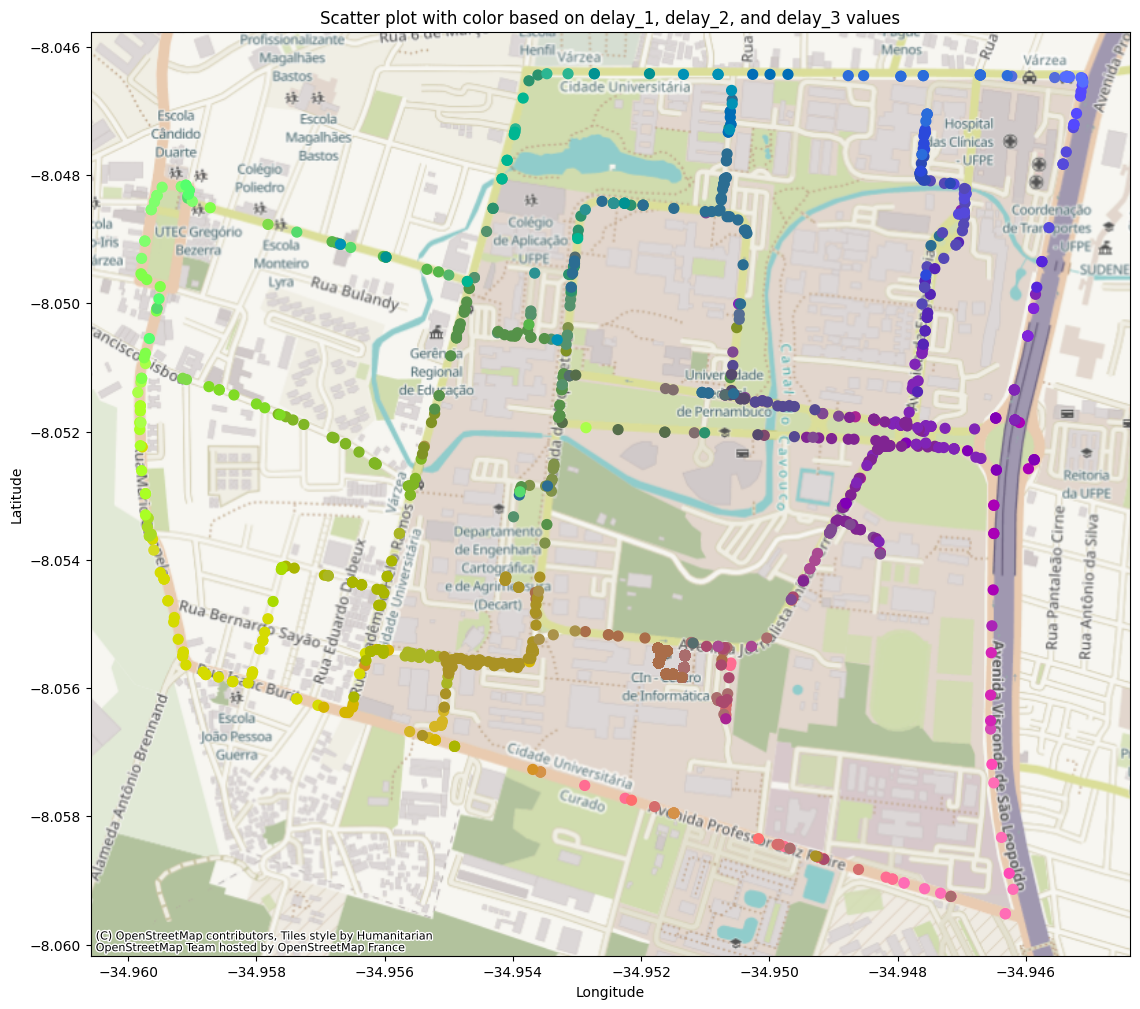

In [117]:
plt.scatter(df_test_alunos['lon_pred'], df_test_alunos['lat_pred'], color= df_test_alunos['color'], s=50)
ctx.add_basemap(plt.gca(), crs='EPSG:4326')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter plot with color based on delay_1, delay_2, and delay_3 values')

plt.gcf().set_size_inches((18,12))
plt.show()

In [118]:
df_test_alunos['ponto_id'] = test_ponto_id
df_result = df_test_alunos[['ponto_id', 'lat_pred', 'lon_pred', 'indoor']]

In [119]:
df_result.to_csv('../../output_data/Resultados_Equipe8_Metodofingerprint.csv')